In [1]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
file_path=r"C:\Users\MSI\OneDrive\Desktop\voicecom\export_emna.xlsx"
df=pd.read_excel(file_path)
sheet_names = pd.ExcelFile(file_path).sheet_names
print("Available sheets:", sheet_names)

Available sheets: ['Sheet1', 'clean_dataset', 'Client_AFF_NRJ_VO_20250116', 'Client_AFF_NRJ_VO_20250106', 'Feuil5', 'Appel_AFF_NRJ_VO_20250116', 'Sheet2']


In [3]:
data=pd.read_excel(pd.ExcelFile(file_path), sheet_name='Client_AFF_NRJ_VO_20250116')
data['Code_str'] = data['CT_ADR_CP'].astype(str)
data['COUNT'] = data['Code_str'].str.len()
data['Code_padded'] = data['Code_str'].str.zfill(5)
data['DEPART'] = data['Code_padded'].str[:2]
data = data[['INDICE','COUNT', 'Code_padded', 'DEPART', 'CT_ADR_VILLE']]
data.columns = ['INDICE','COUNT', 'Code', 'DEPART', 'CT_ADR_VILLE']
print("new data",data.head())

new data    INDICE  COUNT   Code DEPART CT_ADR_VILLE
0     1.0      5  24000     24    PERIGUEUX
1     2.0      5  34080     34  MONTPELLIER
2     3.0      5  26800     26    MONTOISON
3     4.0      5  21000     21        DIJON
4     5.0      5  54180     54  HEILLECOURT


In [4]:
data2 = pd.read_excel(pd.ExcelFile(file_path), sheet_name='Appel_AFF_NRJ_VO_20250116')
merged = pd.merge(data, data2, on='INDICE', how='inner') 
print("here is how it looks : \n",merged.head())
print(merged.shape) #(196189, 114)
merged = merged[(merged['COUNT'] >= 4) & (merged['COUNT'] <= 5)]
merged = merged.reset_index(drop=True)
print("data",merged.head())
print(merged.shape)

here is how it looks : 
    INDICE  COUNT   Code DEPART CT_ADR_VILLE  PRIORITE        DATE  HEURE  \
0     1.0      5  24000     24    PERIGUEUX       -50  20250117.0  935.0   
1     2.0      5  34080     34  MONTPELLIER       -50  20250117.0  935.0   
2     3.0      5  26800     26    MONTOISON       -50  20250117.0  936.0   
3     4.0      5  21000     21        DIJON       -50  20250117.0  936.0   
4     5.0      5  54180     54  HEILLECOURT       -50  20250117.0  936.0   

   VERSOP         RAPPEL  CALLBACK_VALIDITY   TV  ID_TV  STATUSGROUP  STATUS  \
0      -1  Z999999999999                NaN  NaN    0.0          NaN   100.0   
1      -1  Z999999999999                NaN  NaN    0.0          NaN   100.0   
2      -1  Z999999999999                NaN  NaN    0.0          NaN   100.0   
3      -1  Z999999999999                NaN  NaN    0.0          NaN   100.0   
4      -1  Z999999999999                NaN  NaN    0.0          NaN   100.0   

               LIB_STATUS  DETAIL LIB

In [5]:
merged=merged.drop(columns=['COUNT','Code','CT_ADR_VILLE','PRIORITE','VERSOP','RAPPEL','CALLBACK_VALIDITY','TV','ID_TV','DETAIL','LIB_DETAIL','HISTORIQUE'])
print("data\n",merged.head())
print(merged.shape) 
print("sum null is : ",merged.isnull().sum())

data
    INDICE DEPART        DATE  HEURE  STATUSGROUP  STATUS  \
0     1.0     24  20250117.0  935.0          NaN   100.0   
1     2.0     34  20250117.0  935.0          NaN   100.0   
2     3.0     26  20250117.0  936.0          NaN   100.0   
3     4.0     21  20250117.0  936.0          NaN   100.0   
4     5.0     54  20250117.0  936.0          NaN   100.0   

               LIB_STATUS  
0       Call Back Disable  
1  No More CallBack Rules  
2  No More CallBack Rules  
3  No More CallBack Rules  
4  No More CallBack Rules  
(196165, 7)
sum null is :  INDICE              0
DEPART              0
DATE           135429
HEURE          135429
STATUSGROUP    188889
STATUS         135429
LIB_STATUS     135429
dtype: int64


In [6]:
merged=merged.dropna(subset=['STATUS'])
print("data\n",merged.head())
print(merged.shape) 
print("sum null is : ",merged.isnull().sum())

data
    INDICE DEPART        DATE  HEURE  STATUSGROUP  STATUS  \
0     1.0     24  20250117.0  935.0          NaN   100.0   
1     2.0     34  20250117.0  935.0          NaN   100.0   
2     3.0     26  20250117.0  936.0          NaN   100.0   
3     4.0     21  20250117.0  936.0          NaN   100.0   
4     5.0     54  20250117.0  936.0          NaN   100.0   

               LIB_STATUS  
0       Call Back Disable  
1  No More CallBack Rules  
2  No More CallBack Rules  
3  No More CallBack Rules  
4  No More CallBack Rules  
(60736, 7)
sum null is :  INDICE             0
DEPART             0
DATE               0
HEURE              0
STATUSGROUP    53460
STATUS             0
LIB_STATUS         0
dtype: int64


data
    INDICE DEPART    DATE  HEURE  STATUSGROUP  STATUS              LIB_STATUS
0     1.0     24  Friday  935.0          NaN   100.0       Call Back Disable
1     2.0     34  Friday  935.0          NaN   100.0  No More CallBack Rules
2     3.0     26  Friday  936.0          NaN   100.0  No More CallBack Rules
3     4.0     21  Friday  936.0          NaN   100.0  No More CallBack Rules
4     5.0     54  Friday  936.0          NaN   100.0  No More CallBack Rules


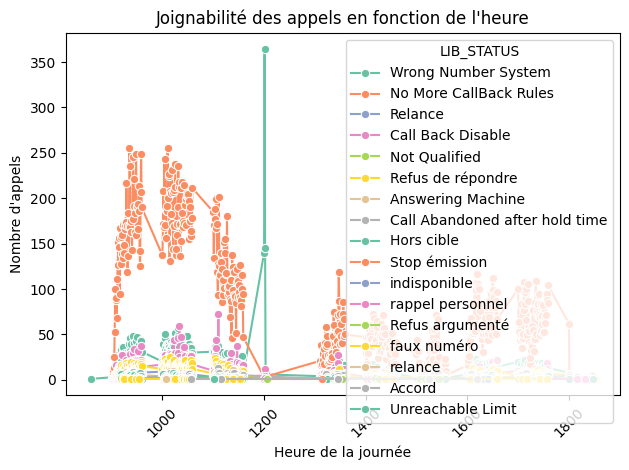

In [7]:
merged['DATE'] = pd.to_datetime(merged['DATE'].astype(int).astype(str), format='%Y%m%d')
merged['DATE'] = merged['DATE'].dt.strftime('%A')

print("data\n",merged.head())

plot_df = (
    merged
    .groupby(['HEURE', 'LIB_STATUS'])
    .size()
    .reset_index(name='count')
)

sns.lineplot(data=plot_df, x='HEURE', y='count', hue='LIB_STATUS', marker='o', palette='Set2')
plt.title("Joignabilité des appels en fonction de l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()


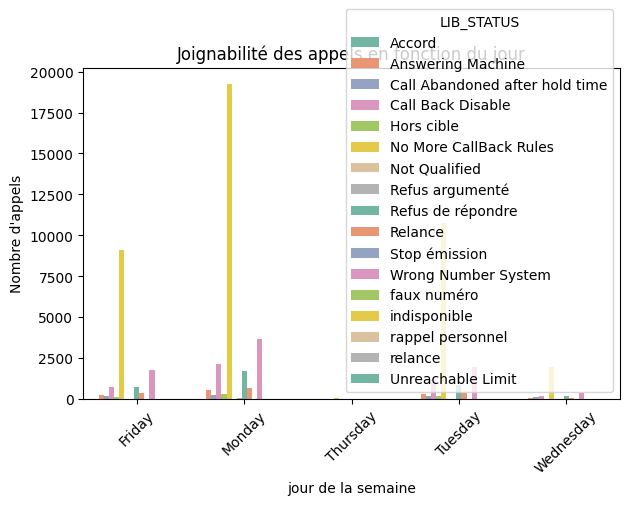

In [8]:
plot_df_2 = (
    merged.groupby(['DATE','LIB_STATUS']).size().reset_index(name='count')
)

sns.barplot(data=plot_df_2, x='DATE', y='count', hue='LIB_STATUS', palette='Set2')
plt.title("Joignabilité des appels en fonction du jour")
plt.xticks(rotation=45)
plt.xlabel("jour de la semaine")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_3820\923343317.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\MSI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


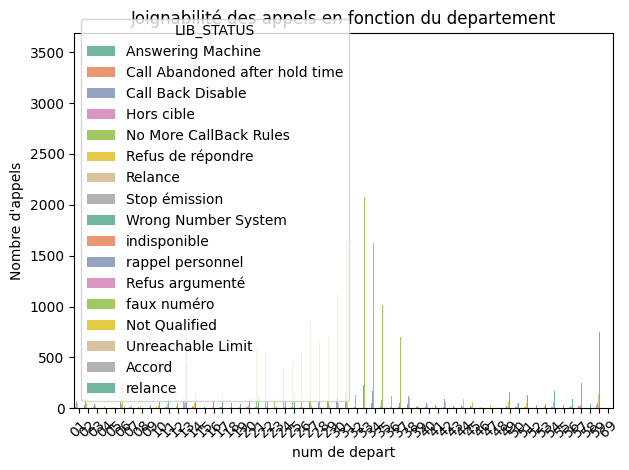

In [9]:
plot_df_3 = (
    merged.groupby(['DEPART','LIB_STATUS']).size().reset_index(name='count')
)

sns.barplot(data=plot_df_3, x='DEPART', y='count', hue='LIB_STATUS', palette='Set2')
plt.title("Joignabilité des appels en fonction du departement")
plt.xticks(rotation=45)
plt.xlabel("num de depart")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()

In [10]:
positive=['Accord', 'Relance', 'rappel personnel' , 'Refus argumenté']
all_statuses = merged['LIB_STATUS'].unique()
negative = [status for status in all_statuses if status not in positive]
print(negative)

['Call Back Disable', 'No More CallBack Rules', 'Refus de répondre', 'Wrong Number System', 'Call Abandoned after hold time', 'Answering Machine', 'Hors cible', 'Not Qualified', 'indisponible', 'faux numéro', 'Stop émission', 'relance', 'Unreachable Limit']


In [11]:
merged['Call_Status'] = merged['LIB_STATUS'].apply(lambda x: 'positive' if x in positive else 'negative')
print(merged.head())

   INDICE DEPART    DATE  HEURE  STATUSGROUP  STATUS              LIB_STATUS  \
0     1.0     24  Friday  935.0          NaN   100.0       Call Back Disable   
1     2.0     34  Friday  935.0          NaN   100.0  No More CallBack Rules   
2     3.0     26  Friday  936.0          NaN   100.0  No More CallBack Rules   
3     4.0     21  Friday  936.0          NaN   100.0  No More CallBack Rules   
4     5.0     54  Friday  936.0          NaN   100.0  No More CallBack Rules   

  Call_Status  
0    negative  
1    negative  
2    negative  
3    negative  
4    negative  


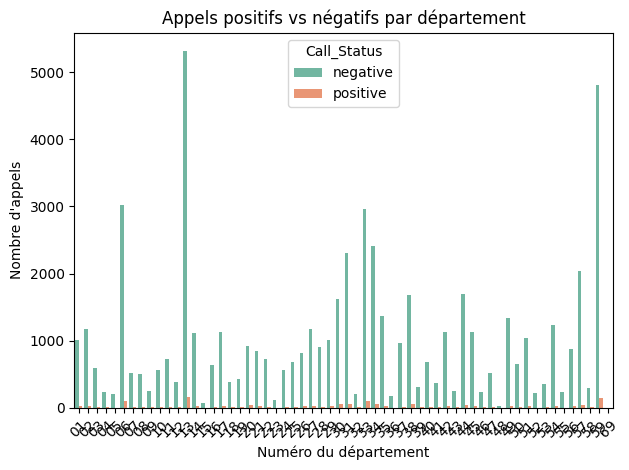

In [12]:
plot_df_4 = (
    merged.groupby(['DEPART', 'Call_Status']).size().reset_index(name='count')
)

sns.barplot(data=plot_df_4, x='DEPART', y='count', hue='Call_Status', palette='Set2')
plt.title("Appels positifs vs négatifs par département")
plt.xticks(rotation=45)
plt.xlabel("Numéro du département")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()

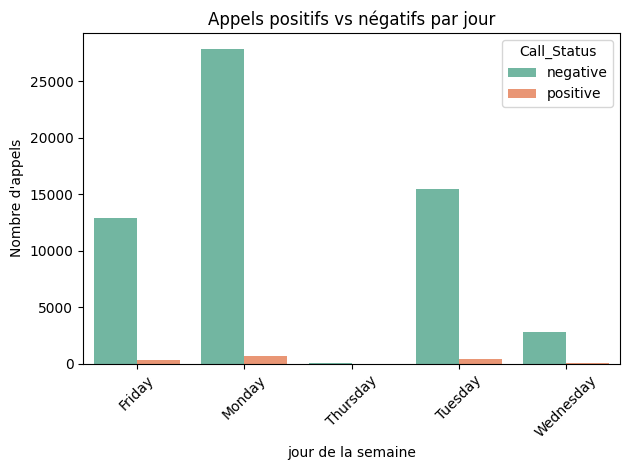

In [13]:
plot_df_5 = (
    merged.groupby(['DATE','Call_Status']).size().reset_index(name='count')
)

sns.barplot(data=plot_df_5, x='DATE', y='count', hue='Call_Status', palette='Set2')
plt.title("Appels positifs vs négatifs par jour")
plt.xticks(rotation=45)
plt.xlabel("jour de la semaine")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()

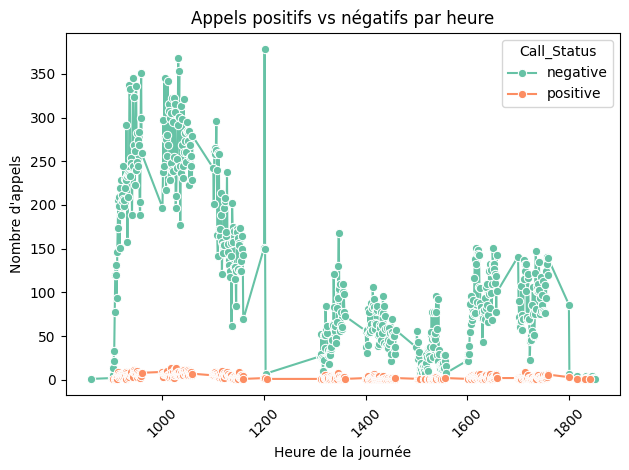

In [14]:
plot_df_6 = (
    merged
    .groupby(['HEURE', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

sns.lineplot(data=plot_df_6, x='HEURE', y='count', hue='Call_Status', marker='o', palette='Set2')
plt.title("Appels positifs vs négatifs par heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre d'appels")
plt.tight_layout()
plt.show()

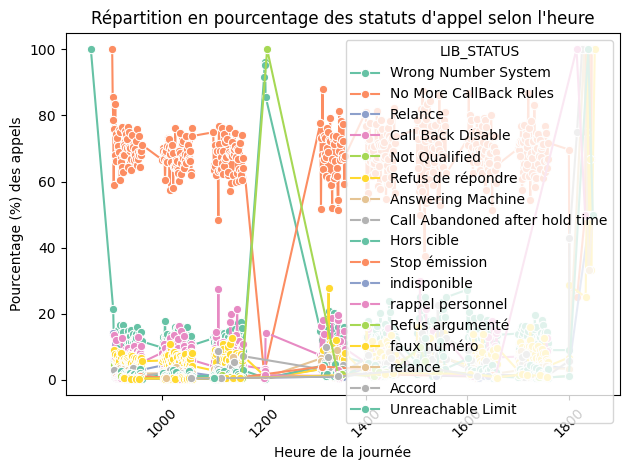

In [15]:
plot_df_per = (
    merged
    .groupby(['HEURE', 'LIB_STATUS'])
    .size()
    .reset_index(name='count')
)

total_per_hour = (
    plot_df
    .groupby('HEURE')['count']
    .transform('sum')  
)

plot_df_per['percentage'] = plot_df_per['count'] / total_per_hour * 100

sns.lineplot(data=plot_df_per, x='HEURE', y='percentage', hue='LIB_STATUS', marker='o', palette='Set2')
plt.title("Répartition en pourcentage des statuts d'appel selon l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Pourcentage (%) des appels")
plt.tight_layout()
plt.show()


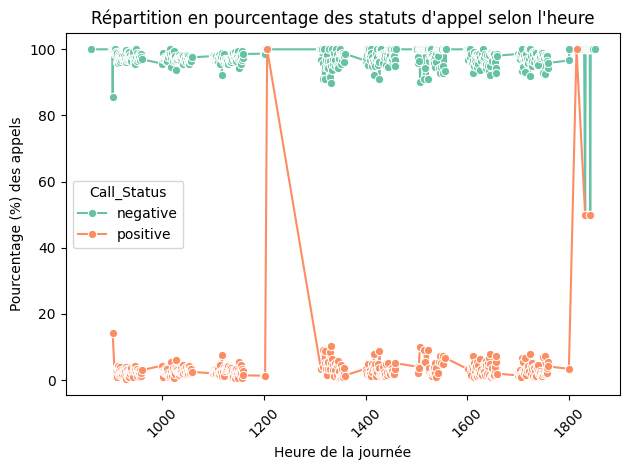

In [16]:
plot_df_per_1 = (
    merged
    .groupby(['HEURE', 'Call_Status'])
    .size()
    .reset_index(name='count')
)


plot_df_per_1['total'] = plot_df_per_1.groupby('HEURE')['count'].transform('sum')
plot_df_per_1['percentage'] = plot_df_per_1['count'] / plot_df_per_1['total'] * 100


sns.lineplot(data=plot_df_per_1, x='HEURE', y='percentage', hue='Call_Status', marker='o', palette='Set2')
plt.title("Répartition en pourcentage des statuts d'appel selon l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Pourcentage (%) des appels")
plt.tight_layout()
plt.show()


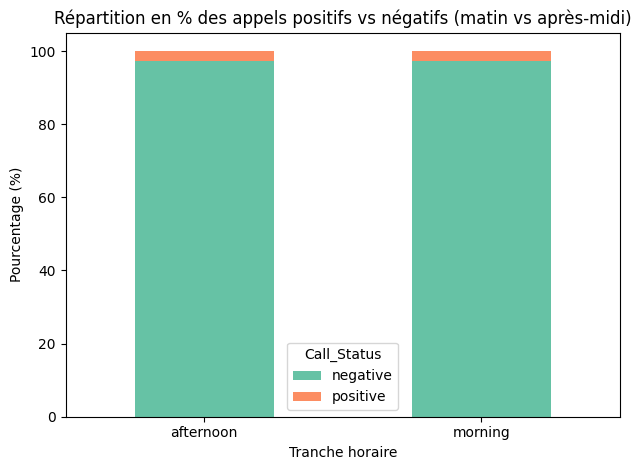

In [17]:

merged['HOUR_INT'] = merged['HEURE'].astype(str).str.zfill(4).str[:2].astype(int)
merged['Time_Block'] = merged['HOUR_INT'].apply(lambda h: 'morning' if 8 <= h < 13 else 'afternoon')

plot_df = (
    merged
    .groupby(['Time_Block', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('Time_Block')['count'].transform('sum')

plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100


pivot_df = plot_df.pivot(index='Time_Block', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs (matin vs après-midi)")
plt.xlabel("Tranche horaire")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()



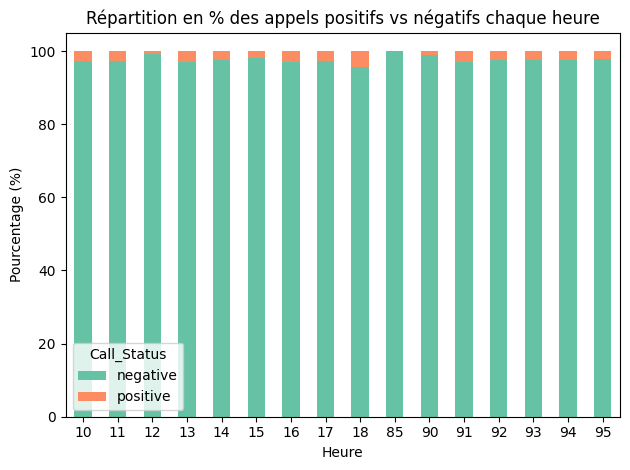

In [18]:

merged['HOUR_INT'] = merged['HEURE'].astype(str).str.zfill(4).str[:2].astype(int)
plot_df = (
    merged
    .groupby(['HOUR_INT', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('HOUR_INT')['count'].transform('sum')

plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100


pivot_df = plot_df.pivot(index='HOUR_INT', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs chaque heure")
plt.xlabel("Heure")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()

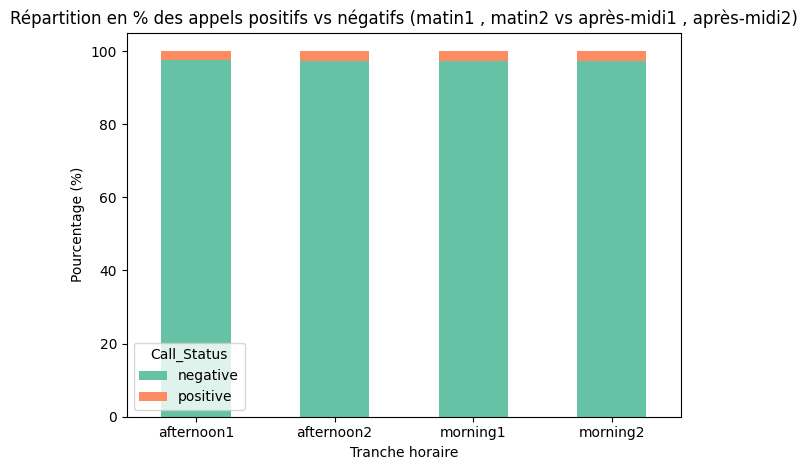

In [19]:

merged['rep'] = merged['HOUR_INT'].apply(
    lambda h: 'morning1' if 8 <= h <= 10 
    else 'morning2' if 10 < h <= 12 
    else 'afternoon1' if 13 <= h <= 15 
    else 'afternoon2'
)
plot_df = (
    merged
    .groupby(['rep', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('rep')['count'].transform('sum')

plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100


pivot_df = plot_df.pivot(index='rep', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs (matin1 , matin2 vs après-midi1 , après-midi2)")
plt.xlabel("Tranche horaire")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()


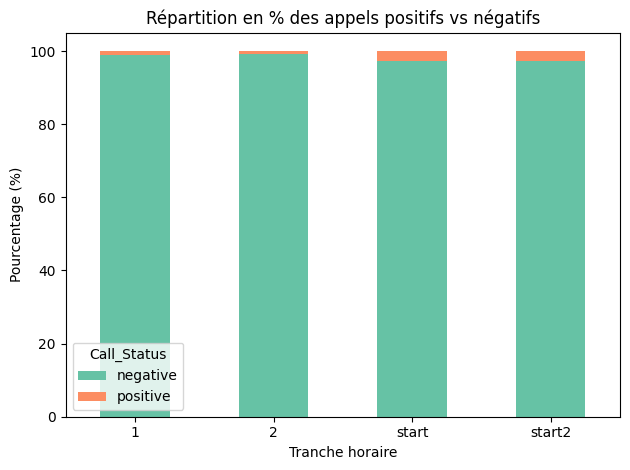

In [20]:

merged['rep'] = merged['HOUR_INT'].apply(
    lambda h: '1' if 85 <= h <=90 
    else 'start' if 9 <= h < 12 
    else '2' if 12 == h 
    else 'start2'
)
plot_df = (
    merged
    .groupby(['rep', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('rep')['count'].transform('sum')

plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100


pivot_df = plot_df.pivot(index='rep', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs")
plt.xlabel("Tranche horaire")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()


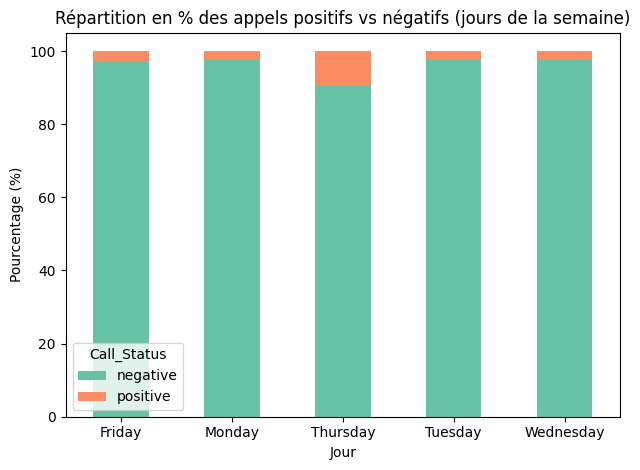

In [21]:
plot_df = (
    merged
    .groupby(['DATE', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('DATE')['count'].transform('sum')
plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100

pivot_df = plot_df.pivot(index='DATE', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs (jours de la semaine)")
plt.xlabel("Jour")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()

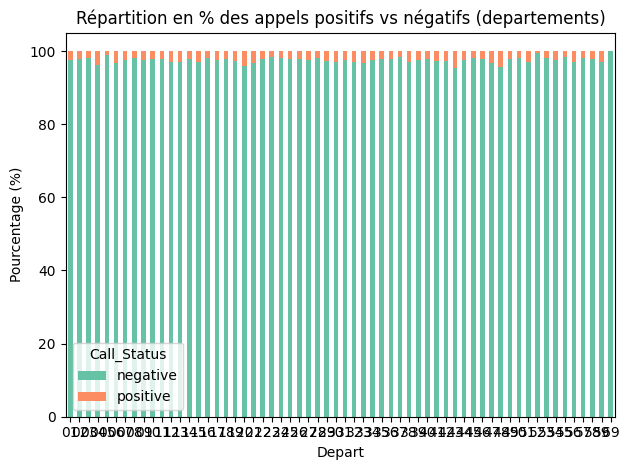

In [22]:
plot_df = (
    merged
    .groupby(['DEPART', 'Call_Status'])
    .size()
    .reset_index(name='count')
)

plot_df['total'] = plot_df.groupby('DEPART')['count'].transform('sum')
plot_df['percentage'] = plot_df['count'] / plot_df['total'] * 100

pivot_df = plot_df.pivot(index='DEPART', columns='Call_Status', values='percentage').fillna(0)

pivot_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
plt.title("Répartition en % des appels positifs vs négatifs (departements)")
plt.xlabel("Depart")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(title='Call_Status')
plt.tight_layout()
plt.show()

In [23]:
print (max(merged['DEPART']))

69


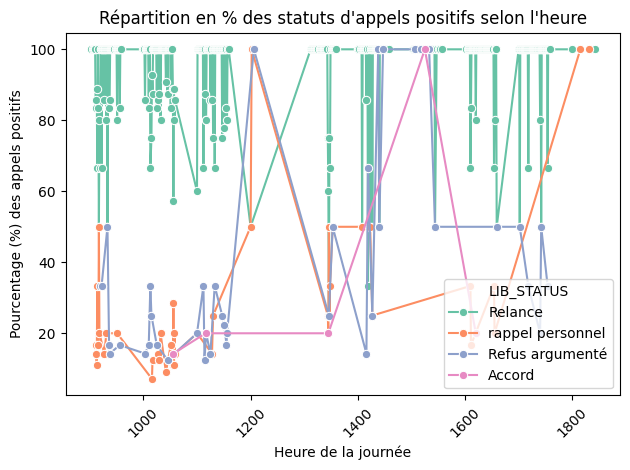

In [27]:
positive = ['Accord', 'Relance', 'rappel personnel', 'Refus argumenté']
filtered = merged[merged['LIB_STATUS'].isin(positive)]
plot_df_per = (
    filtered
    .groupby(['HEURE', 'LIB_STATUS'])
    .size()
    .reset_index(name='count')
)

plot_df_per['total'] = plot_df_per.groupby('HEURE')['count'].transform('sum')
plot_df_per['percentage'] = plot_df_per['count'] / plot_df_per['total'] * 100

sns.lineplot(data=plot_df_per, x='HEURE', y='percentage', hue='LIB_STATUS', marker='o', palette='Set2')
plt.title("Répartition en % des statuts d'appels positifs selon l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Pourcentage (%) des appels positifs")
plt.tight_layout()
plt.show()



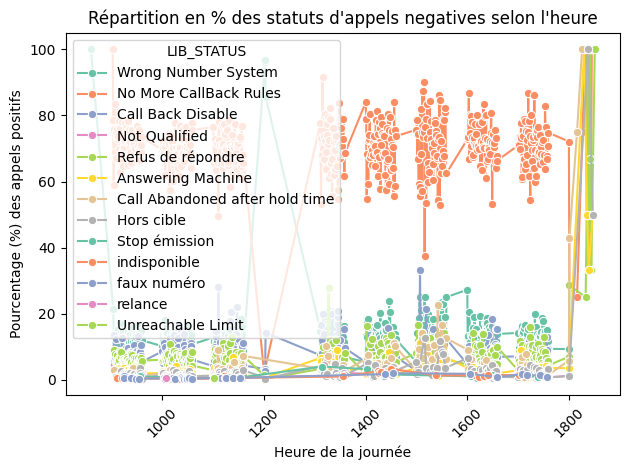

In [28]:
filtered = merged[merged['LIB_STATUS'].isin(negative)]
plot_df_per = (
    filtered
    .groupby(['HEURE', 'LIB_STATUS'])
    .size()
    .reset_index(name='count')
)

plot_df_per['total'] = plot_df_per.groupby('HEURE')['count'].transform('sum')
plot_df_per['percentage'] = plot_df_per['count'] / plot_df_per['total'] * 100

sns.lineplot(data=plot_df_per, x='HEURE', y='percentage', hue='LIB_STATUS', marker='o', palette='Set2')
plt.title("Répartition en % des statuts d'appels negatives selon l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Pourcentage (%) des appels positifs")
plt.tight_layout()
plt.show()

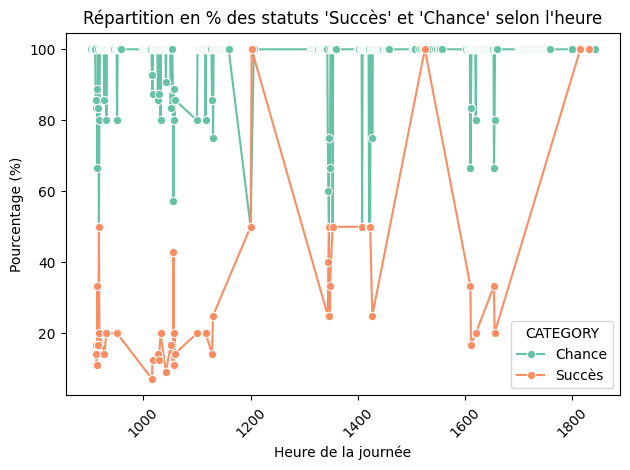

In [29]:
success = ['Accord', 'rappel personnel']
chance = ['Relance', 'Refus argumenté']

filtered = merged[merged['LIB_STATUS'].isin(success + chance)].copy()

filtered.loc[:, 'CATEGORY'] = filtered['LIB_STATUS'].map(lambda x: 'Succès' if x in success else 'Chance')

plot_df_per = (
    filtered
    .groupby(['HEURE', 'CATEGORY'])
    .size()
    .reset_index(name='count')
)

plot_df_per['total'] = plot_df_per.groupby('HEURE')['count'].transform('sum')
plot_df_per['percentage'] = plot_df_per['count'] / plot_df_per['total'] * 100


sns.lineplot(data=plot_df_per, x='HEURE', y='percentage', hue='CATEGORY', marker='o', palette='Set2')
plt.title("Répartition en % des statuts 'Succès' et 'Chance' selon l'heure")
plt.xticks(rotation=45)
plt.xlabel("Heure de la journée")
plt.ylabel("Pourcentage (%)")
plt.tight_layout()
plt.show()